# Approximate Bayesian Computation: an example? 

Discussion from [Joel Akereta et al. 2015; arXiv:1504.07245v3](https://arxiv.org/pdf/1504.07245.pdf): 

> Let us consider a data set $y$ and a model parametrised by a set of parameters $\theta$. From Bayes' theorem, the posterior probability of the model given the data is

$$ p ( \theta | y ) = \frac { p ( y | \theta ) p ( \theta ) } { p ( y ) } $$

> where $p ( y | \theta )$ is the likelihood probability of the data given the model, $p(\theta)$ is the prior probability of the model and the normalisation comes from $p(y)$, the evidence. This expression can be used to derive the posterior from the likelihood and the prior.

> Standard Bayesian inference relies on the evaluation of a likelihood. However, such a function is often not available for simulation-based models. In Approximate Bayesian Computation this problem is bypassed by considering a distance metric $\rho(x, y)$ that quantifies the difference between a simulated ($x$) and an observed ($y$) dataset. ABC algorithms sample the prior, $p(\theta)$, and a candidate parameter $\theta^*$ is accepted and retained as sample of the approximated posterior, if the distance $\rho(x, y)$ between $x$ and $y$ is less than a specified threshold $\epsilon$. For small values of $\epsilon$, the ABC approximation to the posterior $p(\theta | y)$ is

$$ p ( \theta | y ) \simeq p ( \theta | \rho ( x , y ) \leq \epsilon ) $$

*** 

Let's try this on a simple example. Let's say our observations are a bunch of samples from a Gaussian distribution $\mathcal{N}(\mu=2, \sigma^2=1)$ and call it `ref_sample`. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import anderson_ksamp

nsamples = 1000
ref_sample = np.random.normal(loc=2, scale=1, size=nsamples)

Here's the plan: 
1. Define two chains: one to solve for the mean, another for the standard deviation
2. Initialize each chain with a (very) good initial guess
3. Propose a new step: perturb the previous step by drawing from a narrow Gaussian
4. Apply the prior: check if the new step is within the bounds $-10 < \mu < 10$ and $-10 < \sigma < 10$
5. Draw samples from the model distribution with proposed $\mu, \,\sigma$ (which happens to also be a Gaussian distribution)
6. For our distance metric, we'll compute the [Anderson-Darling statistic](https://en.wikipedia.org/wiki/Anderson–Darling_test). If the A-D statistic is less than critical value $\epsilon = -0.5$, i.e. if the distribution is very similar to the reference sample, then accept the step
7. Add the new $\mu,\,\sigma$ to the chains, go back to step (3).

In [190]:
n_steps = 10000

# Steps 1-2
step = 0
init_mean = 2
init_std = 1
means = [init_mean]
stds = [init_std] 
ads = []

while step < n_steps: 
    # Step 3
    proposed_mean = 0.1 * np.random.randn() + means[step-1]
    proposed_std = 0.1 * np.random.randn() + stds[step-1]

    # Step 4
    if -10 < proposed_mean < 10 and -10 < proposed_std < 10: 
        # Step 5
        trial_sample = np.random.normal(loc=proposed_mean, scale=proposed_std, size=nsamples)
        # Step 6
        ad = anderson_ksamp([trial_sample, ref_sample]).statistic
        
        if ad < -0.5:
            # Step 7
            step += 1
            means.append(proposed_mean)
            stds.append(proposed_std)
            ads.append(ad)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1680: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


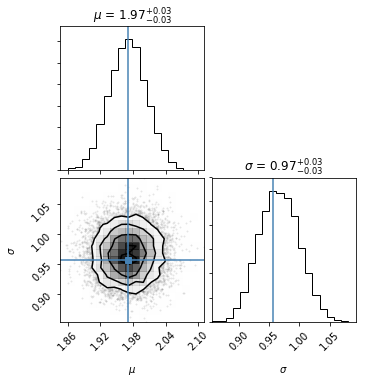

In [191]:
corner(np.array([means, stds]).T, labels='$\mu$ $\sigma$'.split(), show_titles=True,
       truths=[ref_sample.mean(), ref_sample.std()]);

If you choose a more negative value for $\epsilon$, you get smaller posterior uncertainties.

***

The analytic answer for the mean and standard deviation of the mean is: 

In [189]:
ref_sample.mean(), 1/np.sqrt(nsamples)

(1.9707304825024838, 0.031622776601683791)

*** 

We can recover these results via MCMC with the following likelihood: 

In [196]:
import emcee

y = ref_sample.copy()
def lnlike(p):
    mu, lnV = p
    var = np.exp(lnV)
    return np.sum(-0.5 * ((mu - y) ** 2 / var + np.log(var)))

nwalkers, ndim = 10, 2

p0 = [1e-5*np.random.randn() + np.array([2, 0]) for _ in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike)

# Run a burn-in chain and save the final location.
pos = sampler.run_mcmc(p0, 500)[0]

# Run the production chain.
sampler.reset()
sampler.run_mcmc(pos, 1500);

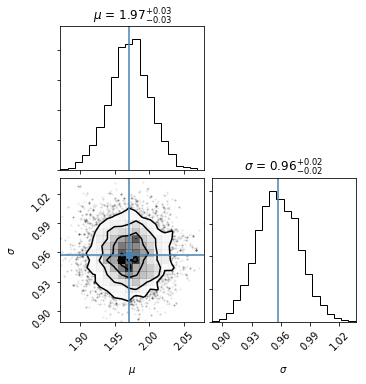

In [197]:
samples = sampler.flatchain.copy()

samples[:, 1] = np.sqrt(np.exp(samples[:, 1]))

corner(samples, truths=[ref_sample.mean(), ref_sample.std()], 
       labels='$\\mu$ $\sigma$'.split(), show_titles=True);